In [1]:
import numpy as np


def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.001,
                           max_lr=0.006,
                           mode='triangular',
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)

    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    
    if mode == 'triangular':
        pass
    elif mode == 'triangular2':
        lr_delta = lr_delta * 1 / (2. ** (cycle - 1))
    elif mode == 'exp_range':
        lr_delta = lr_delta * (gamma**(batch_step))
    else:
        raise ValueError('mode must be "triangular", "triangular2", or "exp_range"')
        
    lr = base_lr + lr_delta
    
    return lr

In [2]:
num_epochs = 50
num_train = 50000
batch_size = 100
iter_per_ep = num_train // batch_size

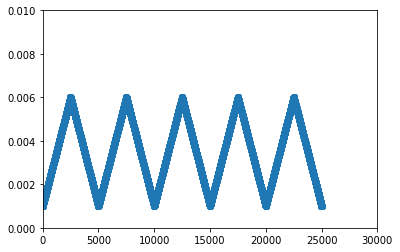

In [3]:
import matplotlib.pyplot as plt


batch_step = -1
collect_lr = []
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*5)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

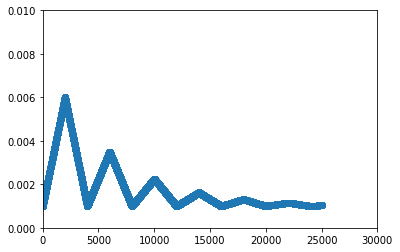

In [4]:
collect_lr = []
batch_step = -1
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*4,
                                        mode='triangular2')
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

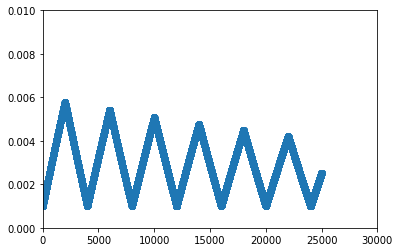

In [5]:

collect_lr = []
batch_step = -1
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*4,
                                        mode='exp_range',
                                        gamma=0.99998)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

In [6]:

import time
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader


In [7]:
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
batch_size = 128

# Architecture
num_classes = 10


##########################
### CIFAR-10 DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range

## Create a validation dataset
np.random.seed(random_seed)
idx = np.arange(50000) # the size of CIFAR10-train
np.random.shuffle(idx)
val_idx, train_idx = idx[:1000], idx[1000:]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          # shuffle=True, # Subsetsampler already shuffles
                          sampler=train_sampler)

val_loader = DataLoader(dataset=train_dataset, 
                        batch_size=batch_size, 
                        # shuffle=True,
                        sampler=val_sampler)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
cnt = 0
for images, labels in train_loader: 
    cnt += images.shape[0]
print('Number of training examples:', cnt)

cnt = 0
for images, labels in val_loader: 
    cnt += images.shape[0]
print('Number of validation instances:', cnt)

cnt = 0
for images, labels in test_loader: 
    cnt += images.shape[0]
print('Number of test instances:', cnt)


Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Number of training examples: 49000
Number of validation instances: 1000
Number of test instances: 10000


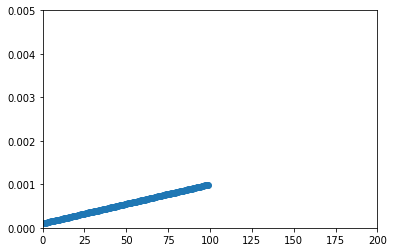

In [27]:
num_epochs = 50
iter_per_ep = int(len(train_loader)/batch_size)
base_lr = 0.0001
max_lr = 0.001

batch_step = -1
collect_lr = []
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=num_epochs*iter_per_ep,
                                        base_lr=base_lr,
                                        max_lr=max_lr)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.005])
plt.xlim([0, num_epochs*iter_per_ep +100])
plt.show()

In [9]:
def metric_acc(net, data_loader):
    net.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            proba = net(features)
            _, predicted = torch.max(proba, 1)
            num_examples +=targets.size(0)
            correct_pred += (predicted == targets).sum()
        return correct_pred.float()/num_examples*100

In [34]:
from torchvision import models
from torch.optim.lr_scheduler import CyclicLR
import torch
import torch.nn as nn

num_epochs = 10
iter_per_ep = len(train_loader)/batch_size
base_lr = 0.0001
max_lr = 0.001

torch.manual_seed(1)
model = models.resnet18(pretrained=True)

model.fc = nn.Linear(in_features = 512, out_features=10, bias=True)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
scheduler = CyclicLR(optimizer,base_lr=1e-3,max_lr=1e-2,step_size_up=num_epochs*iter_per_ep)

collect = {'epoch': [], 'cost': [], 'train_batch_acc': [], 'val_acc': []}

batch_step = -1
cur_lr = base_lr

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        batch_step+=1
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        out = model(features)
        loss = criterion(out, targets)
        optimizer.zero_grad()
        
        loss.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #############################################
        # Logging
      

        #############################################
        # Collect stats    
    model = model.eval()
    train_acc = metric_acc(model, [[features, targets]])
    val_acc = metric_acc(model, val_loader)
    collect['epoch'].append(cur_lr)
    collect['train_batch_acc'].append(train_acc)
    collect['val_acc'].append(val_acc)
    collect['cost'].append(loss)

    print('Epoch %3d' % (epoch+1), end='')
    print('  |  Train/Valid Acc: %.2f/%.2f' % (train_acc, val_acc))   
        #############################################
        # update learning rate
#     cur_lr = cyclical_learning_rate(batch_step=batch_step,
#                                     step_size=num_epochs*iter_per_ep,
#                                     base_lr=base_lr,
#                                     max_lr=max_lr)
#     for g in optimizer.param_groups:
#         g['lr'] = cur_lr
        ############################################

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch   1  |  Train/Valid Acc: 73.08/71.20
Time elapsed: 0.18 min
Epoch   2  |  Train/Valid Acc: 78.85/76.30
Time elapsed: 0.35 min
Epoch   3  |  Train/Valid Acc: 86.54/77.80
Time elapsed: 0.52 min
Epoch   4  |  Train/Valid Acc: 86.54/76.90
Time elapsed: 0.70 min
Epoch   5  |  Train/Valid Acc: 90.38/79.00
Time elapsed: 0.87 min
Epoch   6  |  Train/Valid Acc: 95.19/79.10
Time elapsed: 1.04 min
Epoch   7  |  Train/Valid Acc: 96.15/78.30
Time elapsed: 1.22 min
Epoch   8  |  Train/Valid Acc: 97.12/78.40
Time elapsed: 1.39 min
Epoch   9  |  Train/Valid Acc: 99.04/79.00
Time elapsed: 1.56 min
Epoch  10  |  Train/Valid Acc: 99.04/79.40
Time elapsed: 1.74 min
Total Training Time: 1.74 min


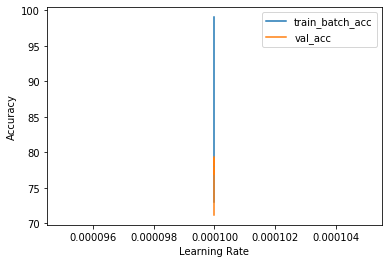

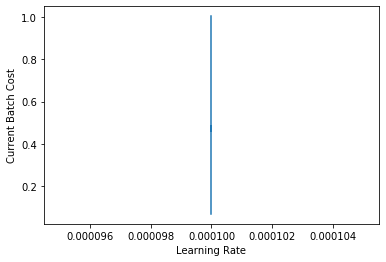

In [36]:
plt.plot(collect['epoch'], collect['train_batch_acc'], label='train_batch_acc')
plt.plot(collect['epoch'], collect['val_acc'], label='val_acc')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(collect['epoch'], collect['cost'])
plt.xlabel('Learning Rate')
plt.ylabel('Current Batch Cost')
plt.show()